In [22]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np

In [27]:
from functools import partial
import os

# from ray import tune
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

AttributeError: partially initialized module 'ray' has no attribute '_private' (most likely due to a circular import)

In [20]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.FashionMNIST(data_dir, download=False, train=True, transform=transform)
    testset = datasets.FashionMNIST(data_dir, download=False, train=False, transform=transform)
    validationset, testset = torch.utils.data.random_split(testset, lengths=(5000,5000))
    
    return trainset, testset, validationset

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [4]:
trainset, testset, validationset = load_data()

In [5]:
batch_size = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
def manager(model, loader, mode, criterion, device, optimizer):
    model.to(device)
    loss = 0.0
    accuracy = []
    
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    for i, data in enumerate(loader, 0):    
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(mode == 'train'):
            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_ = criterion(outputs, labels)
            
            loss += loss_.item()
            accuracy.append((torch.sum(preds == labels.data)/len(preds)).cpu())
            
            if mode == 'train':
                loss_.backward()
                optimizer.step()
    
    return model, loss/len(loader), np.mean(accuracy)
        

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

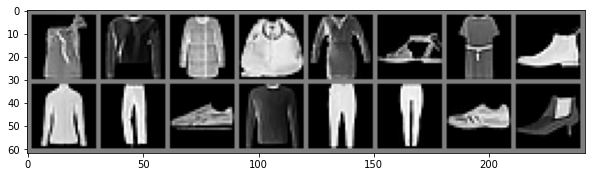

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.figure(figsize=(10,8))
imshow(torchvision.utils.make_grid(images[:16]))

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    # define forward function
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        # don't need softmax here since we'll use cross-entropy as activation.

        return t

net = Network()

In [9]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
train_losses = []
validation_losses = []
train_acc = []
validation_acc = []
phase = ['train', 'validation']

EPOCHS = 2

for epoch in range(1,EPOCHS+1):    
    for p in phase:
        loader = trainloader if p == 'train' else validationloader
        net, l, a = manager(net, loader, p, criterion, device, optimizer)
        
        if p == 'train':
            train_losses.append(l)
            train_acc.append(a)
        else:
            validation_losses.append(l)
            validation_acc.append(a)
    # if epoch%5 == 0:
    print(f"EPOCH {epoch}")
    print(f"Train loss: {train_losses[epoch-1]}")
    print(f"Train accuracy: {train_acc[epoch-1]}")
    print(f"Validation loss: {validation_losses[epoch-1]}")
    print(f"Validation accuracy: {validation_acc[epoch-1]}")
    print("---------------------")
    

print('Finished Training')

EPOCH 1
Train loss: 1.0669797608407878
Train accuracy: 0.6375794410705566
Validation loss: 0.6455287098884582
Validation accuracy: 0.7542330622673035
---------------------
EPOCH 2
Train loss: 0.5658800132193808
Train accuracy: 0.7821769118309021
Validation loss: 0.5358879834413528
Validation accuracy: 0.7977837920188904
---------------------
Finished Training


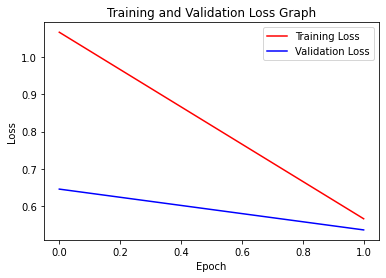

In [12]:
plt.plot(train_losses, label='Training Loss', color='r')
plt.plot(validation_losses, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

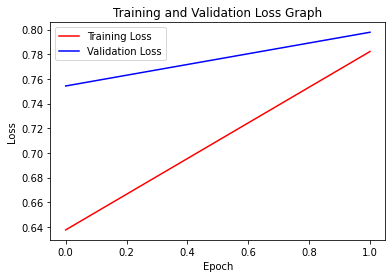

In [13]:
plt.plot(train_acc, label='Training Loss', color='r')
plt.plot(validation_acc, label='Validation Loss', color='b')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Graph")
plt.legend()
plt.show()

In [15]:
def train_mnist(config, trainset, validationset, checkpoint_dir=None, data_dir=None):
    net = Net()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # trainset, testset = load_data(data_dir)

    # test_abs = int(len(trainset) * 0.8)
    # train_subset, val_subset = random_split(
        # trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        validationset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [16]:
config = {
    "lr" : tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
}

NameError: name 'tune' is not defined